# **Lab4 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure
from mpl_toolkits.axes_grid1 import ImageGrid

import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os
import random

## Load Image

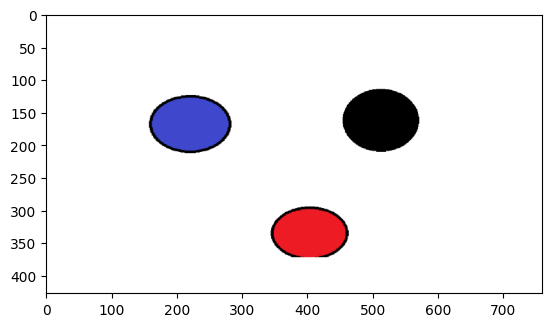

In [ ]:
### START CODE HERE ###
image = cv2.imread("/content/three_ball.png")
image = cv2.resize(image, (int(image.shape[1]*0.66), int(image.shape[0]*0.66)))
image = image[:, :, ::-1]
plt.imshow(image)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/1.png?raw=true)
</details>

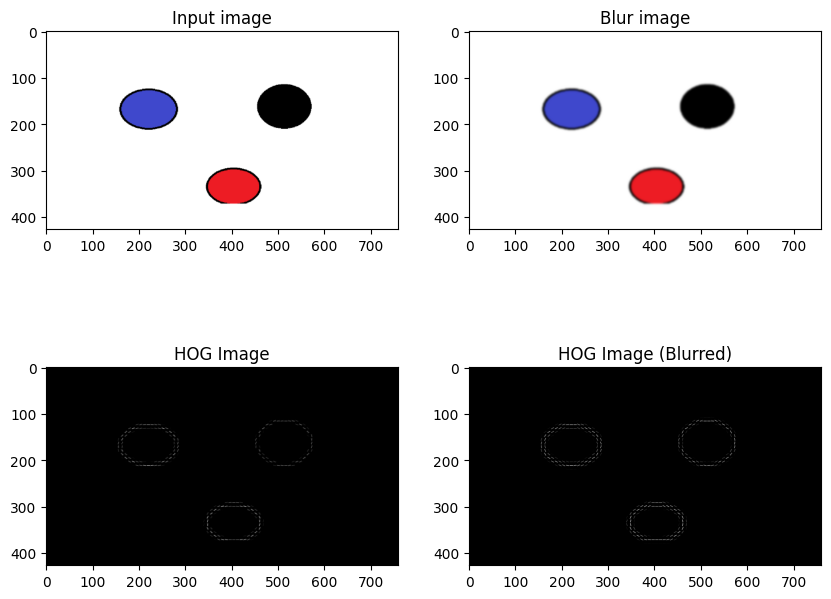

In [ ]:
### START CODE HERE ###

# blur image by GaussianBlur (image, (kernel size), sd of blur)
# sd = 0 auto set sigma
blur_image = cv2.GaussianBlur(image, (11, 11), 0)

# hog by original image
features, hog_image = hog(image, visualize=True, channel_axis=2 )
features, hog_blur_image = hog(blur_image, visualize=True, channel_axis=2)

# plot
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

### before HOG function
# original image
axs[0, 0].imshow(image)
axs[0, 0].set_title('Input image')

# original blur image
axs[0, 1].imshow(blur_image)
axs[0, 1].set_title('Blur image')

### after HOG function
# original image
axs[1, 0].imshow(hog_image, cmap='gray')
axs[1, 0].set_title('HOG Image')

# original blur image
axs[1, 1].imshow(hog_blur_image, cmap='gray')
axs[1, 1].set_title('HOG Image (Blurred)')

plt.show()
### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [ ]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.hGrid, self.wGrid = self._calculate_grids()
        self.hog_features = []
        self.hog_images = []
        self.extract_hog_features()

    # calculate grid (position of grid)
    def _calculate_grids(self):
        # calculate the grid indices for rows and columns based on tile_size and stride
        h_indices = list(range(0, self.image.shape[0] - self.tile_size[0] + 1, self.stride[0]))
        w_indices = list(range(0, self.image.shape[1] - self.tile_size[1] + 1, self.stride[1]))
        return h_indices, w_indices

    def extract_hog_features(self):
        # Extract HOG features from each sub-image
        for h in self.hGrid:
            for w in self.wGrid:
                sub_image = self.image[h:h+self.tile_size[0], w:w+self.tile_size[1]]
                # Compute HOG feature(for train model) and HOG image
                hog_sub_image_features, hog_sub_image = hog(sub_image, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, channel_axis=2)
                # Save the HOG feature and the HOG image
                self.hog_features.append(hog_sub_image_features)
                self.hog_images.append(hog_sub_image)

    def plot_hog_images(self):
        # Plot the HOG visualization images from sub-images
        fig = plt.figure(facecolor="black")
        for i , img in enumerate(self.hog_images):
          plt.subplot(int(len(self.hGrid)), int(len(self.wGrid)), i+1)
          plt.imshow(img, cmap="gray")
          plt.axis("off")

    # return number of row and column
    def get_num_grid(self):
        # return number of row and column
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](attachment:image.png)
</details>

Number of grids: (50, 92)


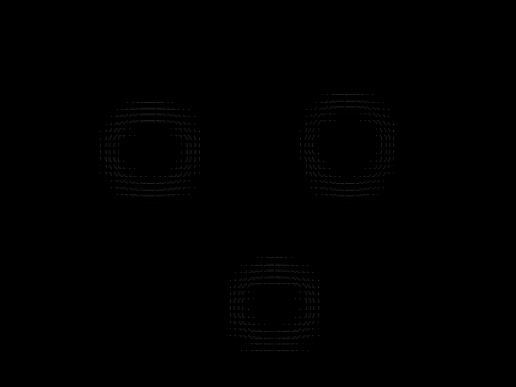

In [ ]:
### START CODE HERE ###
tile_size = (32, 32)
stride = (8, 8)
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
hog_extractor._calculate_grids()
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###


## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [ ]:
### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state):
        # ใช้ hog_extractor ภายใน class
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state # set seed
        self.cluster_array = []
        self.all_labels = []
        self.bounding_boxes = []
        self.perform_clustering()

    # built model perform_clustering by k-mean clustering
    def perform_clustering(self):
        # bulit model k-mean by pass (n_cluster, random_state)
        kmeans = KMeans(random_state=self.random_state, n_clusters=self.n_clusters)
        # ทำ k-mean clustering ในการหา centroid ใน HOG feature
        # โดยจะบอกว่าแต่ละ HOG feature ถูกจัดอยู่ในกลุ่มใด
        cluster_labels = kmeans.fit_predict(self.hog_extractor.hog_features)
        num_grid_x,num_grid_y = hog_extractor.get_num_grid()
        # print("cluster_labels",cluster_labels)
        # cluster_labels ได้ 1D (แปลง cluster_labels เป็น 2D array by .reshape(num_grid_x, num_grid_y))
        self.cluster_array = cluster_labels.reshape(num_grid_x, num_grid_y)
        # print("cluster_array",self.cluster_array)
        # หาส่วนที่เชื่อมต่อกันใน 2D array จับ neighbor ที่เหมือนกัน group กัน
        self.all_labels = measure.label(self.cluster_array)
        # print("all_labels :",self.all_labels)
        print("max",self.all_labels.max())
        print("min",self.all_labels.min())

    # plot cluster and lables
    def plot_cluster_and_labels(self):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(self.cluster_array)
        axes[1].imshow(self.all_labels)
        plt.show()

    # get_bounding_boxes (คำนวนกรอบที่ล้อมรอบ bounding_boxes ของแต่ละกลุ่มที่เชื่อมต่อกันในภาพ)
    # หลังจากที่ได้ทำการจัดกลุ่มด้วย K-means clustering และระบุส่วนที่เชื่อมต่อกันด้วย measure.label
    def get_bounding_boxes(self):
        labels = self.all_labels
        tile_size = self.hog_extractor.tile_size
        stride = self.hog_extractor.stride

        for label in range(0, np.max(labels)+1):
          # return index (x,y) ของ lable กลุ่มนั้นๆที่ loop ไป
          y, x = np.where(label == labels)
          # compute top-left
          y_min, x_min = (y.min() * stride[1], x.min() * stride[0])
          # compute buttom-right
          y_max, x_max = (y.max() * stride[1] + tile_size[1], x.max() * stride[1] + tile_size[0])
          # append (label if loop, top-left, bottom-right)
          self.bounding_boxes.append((label, (x_min, y_min), (x_max, y_max)))
        return self.bounding_boxes
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [ ]:
### START CODE HERE ###
def draw_bbox(image,bboxes):
    image_copy = image.copy() # ไม่ copy แล้วบึ้ม เลยต้อง copy
    for label, (x_min, y_min), (x_max, y_max) in bboxes:
        cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    plt.imshow(image_copy)
### END CODE HERE ###

Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/4.png?raw=true)
</details>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


max 3
min 0


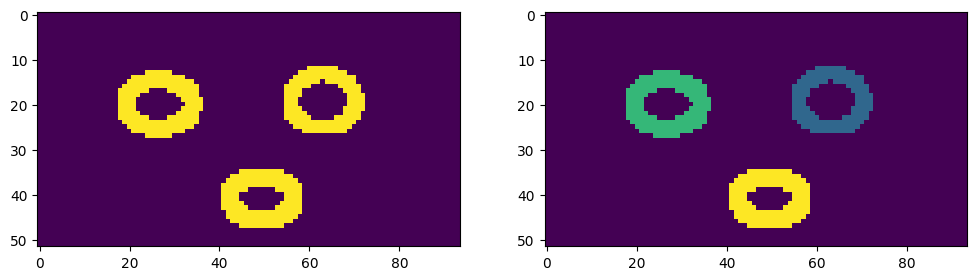

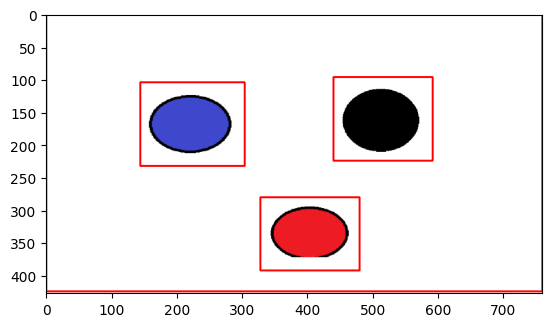

In [ ]:
kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=random.randint(0,199))
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
plt.imshow(image)
draw_bbox(image,bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


max 3
min 0


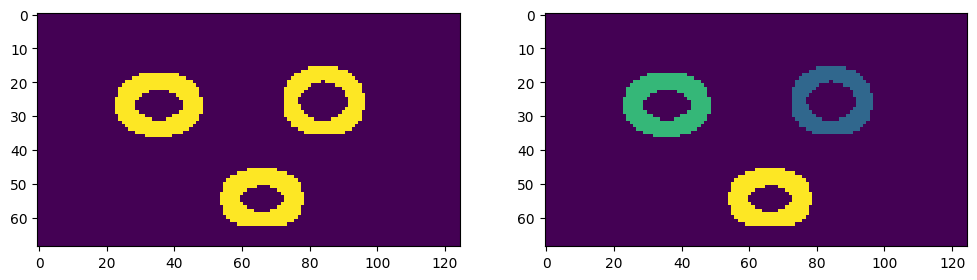

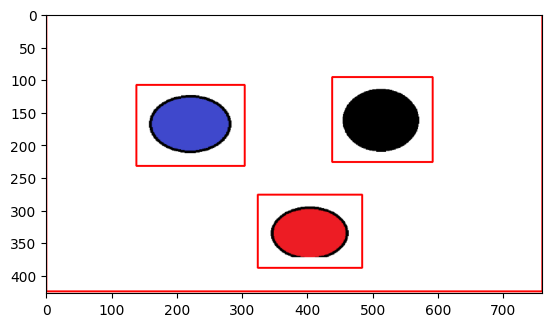

In [ ]:
### START CODE HERE ###
tile_size = (16, 16)
stride = (6, 6)
hog_extractor = HOGSubimageExtractor(blur_image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor,n_clusters=2,random_state=random.randint(0,199))
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
plt.imshow(image)
draw_bbox(image,bboxes)
### END CODE HERE ###

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


max 3
min 0


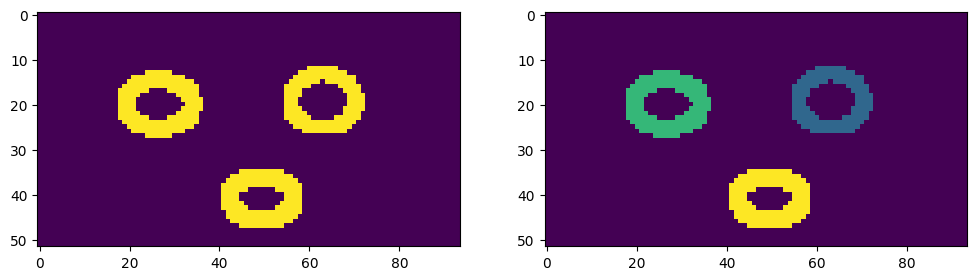

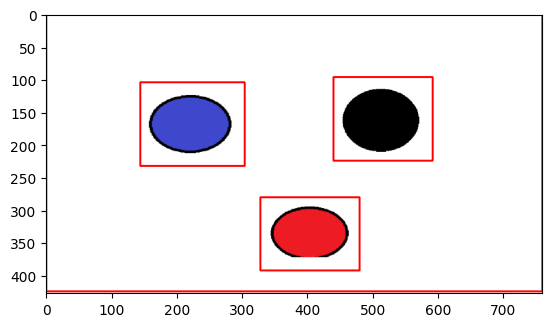

In [ ]:
### START CODE HERE ###
tile_size = (16, 16)
stride = (8, 8)
hog_extractor = HOGSubimageExtractor(blur_image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor,n_clusters=2,random_state=random.randint(0,199))
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
plt.imshow(image)
draw_bbox(image,bboxes)
### END CODE HERE ###

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


max 3
min 0


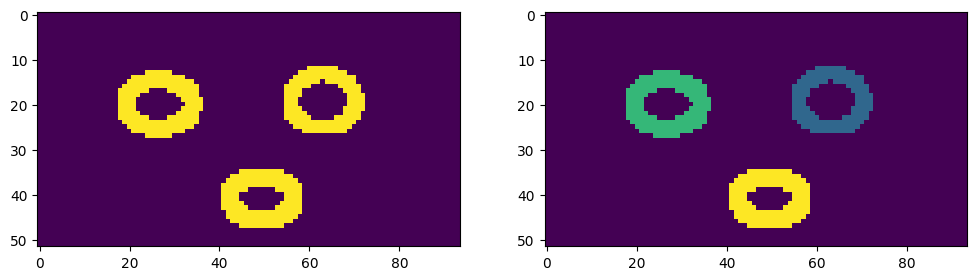

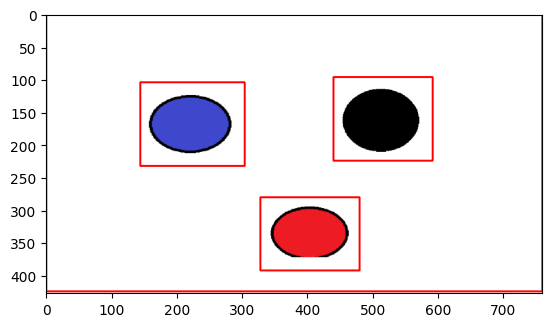

In [ ]:
### START CODE HERE ###
tile_size = (16, 16)
stride = (8, 8)
hog_extractor = HOGSubimageExtractor(blur_image, tile_size, stride)
kmeans_cluster = KMeansCluster(hog_extractor,n_clusters=2,random_state=random.randint(0,199))
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
plt.imshow(image)
draw_bbox(image,bboxes)
### END CODE HERE ###

---

## **Question**
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?</br>
Ans : </br>
<b>Kernel size</b> : kernel size ที่ใหญ่ขึ้นจะทำให้ภาพที่ได้นั้นมีการเบลอมากขึ้น</br><b>SD</b> : ที่มีค่าที่สูงจะทำให้ภาพที่ได้นั้นมีการเบลอมากขึ้น
(การเบลอของภาพนั้นจะทำให้ภาพมีรายละเอียดและขอบลดลงทำให้ภาพหรือกลุ่มก้อนที่ใกล้เคียงกันอาจจะมองเป็นภาพเนื้อเดียวกันได้ แต่ในขณะเดียวกันภาพที่มีการเบลอนั้นก็จะทำให้ภาพมี noise ลดลงได้ด้วยเช่นกัน)
---
2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?</br>
Ans : </br>
<b>pixel per cell</b> : pixel per cell ที่มีขนาดใหญ่นั้นจะทำให้ดักจับหรือดึง feature ได้น้อยลงแต่ก็จะทำให้การดึง noise ที่ไม่จำเป็นนั้นน้อยลงด้วย ในทางกลับกันนั้น ขนาด pixel per cell ที่เล็ก ก็จะทำให้ดึงข้อมูลหรือรายละเอียดของภาพได้มากกว่าซึ่งจะดักจับ feature เล็กๆได้ละเอียดมากขึ้นแต่ก็อาจจะดึง noise ของภาพมาด้วยได้นั่นเอง</br>
<b>cell per box</b> : cell per box ที่มีขนาดเล็กจะทำให้มีความละเอียดในการดัก featrue ได้ดีแต่อาจจะมีความไวต่อแสงและ noise ที่มากขึ้น
cell per box ที่มีขนาดใหญ่จะทำให้ histogram ถูกมองในภาพที่กว่างมากยิ่งขึ้นมีความทนทานต่อการเปลี่ยนแปลงของแสง แต่ก็อาจจะดักจับ feature ได้ไม่ค่อยดีนัก
---
3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?</br>
Ans : </br>
<b>sub-image ที่ใหญ่</b> : Tiles ที่ใหญ่นั้นจะทำให้บริเวณที่มีความแตกต่างกันมากๆนั้นรวมกันเป็นกลุ่มเดียว ซึ่งอาจช่วยลด noise และความไม่สม่ำเสมอของภาพได้ แต่อาจจะพลาดรายละเอียดเล็กๆน้อยๆได้เช่นกัน ซึ่ง tile ที่ใหญ่นั้น จะทำให้มีการแบ่งกลุ่มกันที่น้อยเกินไปอีกด้วย </br>
<b>sub-image ที่เล็ก</b> : Tiles ที่เล็กลงจะให้ความละเอียดในการจัดกลุ่มสูงขึ้น จับการเปลี่ยนแปลงของภาพได้ดี ซึ่งดีสำหรับการตรวจจับโครงสร้างเล็กๆ แต่ก็อาจทำให้เกิดการแบ่งกลุ่มมากเกินไป ทำให้วัตถุหนึ่งถูกแบ่งเป็นหลายกลุ่ม
---
4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering? </br>
Ans : </br>
การทำ measure.label นั้นเป็นการแยกกลุ่มของ object ของวัตถุที่ต่างกันแต่มีการทำ k-means clustering แล้วได้ผลลัพธ์ออกมาเป็นกลุ่มเดียวกัน ให้กลายเป็น object ที่อยู่ต่างกลุ่มกัน ทำให้เมื่อการ get bounding box ของ object ทั้งสองนี้ได้เป็น 2 bounding box เพราะถือว่าเป็น object ที่ต่างกัน แต่หากเราไม่ทำการ label ก็จะทำให้ส่งผลต่อการทำ bounding box เนื่องจากการ get bounding box จะเข้าใจว่า 2 object ที่ต่างกันนี้นั้น เป็น object เดียวกันแล้วก็ตี bounding box ใหญ่ๆ 1 อันออกมาแทนที่ความเป็นจริงควรจะแยก object 2 อันนี้ออกมาเป็น 2 bounding boxes
---
5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)?
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://github.com/Digital-Image-Processing-Laboratory/image_processing-2024/blob/master/Lab4_Image-Segmentation/asset/q5.jpg?raw=true)
